# Deep Convolutional VAE with face emotion data

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
from util import gpusession,plot_grid_imgs
from model import basic_dcvae, lrelu
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages Loaded")

Packages Loaded


Load Data

In [2]:
loadpath = '../data/face_emotion.npz'
l = np.load(loadpath)
trainimg,trainlabel = l['trainimg'],l['trainlabel']
testimg,testlabel = l['testimg'],l['testlabel']
valimg,vallabel = l['valimg'],l['vallabel']
ntrain,ntest,nval = trainimg.shape[0],testimg.shape[0],valimg.shape[0]
X,Y,imgcnt,labels,xshp=l['X'],l['Y'],l['imgcnt'],l['labels'],l['rszshape']
xdim,nclass = X.shape[1],Y.shape[1]
print ("[%d] images with xshape:[%s] and nclass:[%d]"%(X.shape[0],xshp,nclass))
print ("#Train:[%d] #Test[%d] #Validation[%d]"%(ntrain,ntest,nval))

[35886] images with xshape:[[64 64]] and nclass:[7]
#Train:[25120] #Test[7177] #Validation[3589]


Instantiate DCVAE

In [ ]:
V = basic_dcvae(_name='DCVAE',_xdim=xshp,_zdim=32,
                _filtersize=[3,3],_nfilter=64,_actv=tf.nn.tanh,
                _lr=0.001,_beta1=0.9,_beta2=0.99,_epsilon=1e-6)

[DCVAE] Instantiated
 xdim:[[64 64  1]] zdim:[32] nfilter:[64] filtersize:[[3, 3]]
Trainable Variables
 [0] Name:[encoder/conv0/weights:0] Shape:[[3, 3, 1, 64]]
 [1] Name:[encoder/conv0/biases:0] Shape:[[64]]
 [2] Name:[encoder/conv1/weights:0] Shape:[[3, 3, 64, 128]]
 [3] Name:[encoder/conv1/BatchNorm/beta:0] Shape:[[128]]
 [4] Name:[encoder/conv2/weights:0] Shape:[[3, 3, 128, 256]]
 [5] Name:[encoder/conv2/BatchNorm/beta:0] Shape:[[256]]
 [6] Name:[encoder/conv3/weights:0] Shape:[[3, 3, 256, 512]]
 [7] Name:[encoder/conv3/BatchNorm/beta:0] Shape:[[512]]
 [8] Name:[encoder/zmu/weights:0] Shape:[[8192, 32]]
 [9] Name:[encoder/zmu/biases:0] Shape:[[32]]
 [10] Name:[encoder/zlogvar/weights:0] Shape:[[8192, 32]]
 [11] Name:[encoder/zlogvar/biases:0] Shape:[[32]]
 [12] Name:[decoder/lin0/weights:0] Shape:[[32, 8192]]
 [13] Name:[decoder/lin0/biases:0] Shape:[[8192]]
 [14] Name:[decoder/lin0_bn/beta:0] Shape:[[512]]
 [15] Name:[decoder/up1/weights:0] Shape:[[3, 3, 256, 512]]
 [16] Name:[dec

Optimize DCVAE

[0e+00/1e+03 0.0%][kl_weight:0.50] [LOSS] TOTAL[47.2]=RECON[29.4]+KL[35.6]


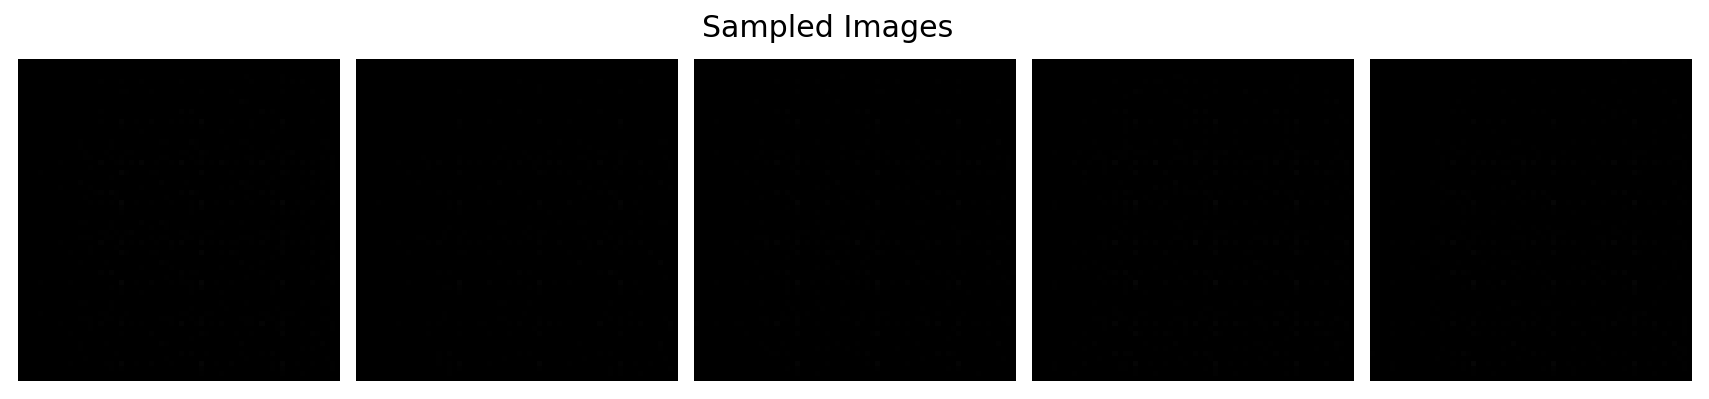

[2e+01/1e+03 2.0%][kl_weight:0.50] [LOSS] TOTAL[17.9]=RECON[16.1]+KL[3.7]
[4e+01/1e+03 4.0%][kl_weight:0.50] [LOSS] TOTAL[15.9]=RECON[15.3]+KL[1.1]
[6e+01/1e+03 6.0%][kl_weight:0.50] [LOSS] TOTAL[15.7]=RECON[15.5]+KL[0.5]
[8e+01/1e+03 8.0%][kl_weight:0.50] [LOSS] TOTAL[15.3]=RECON[15.1]+KL[0.2]
[1e+02/1e+03 10.0%][kl_weight:0.50] [LOSS] TOTAL[14.9]=RECON[14.7]+KL[0.3]


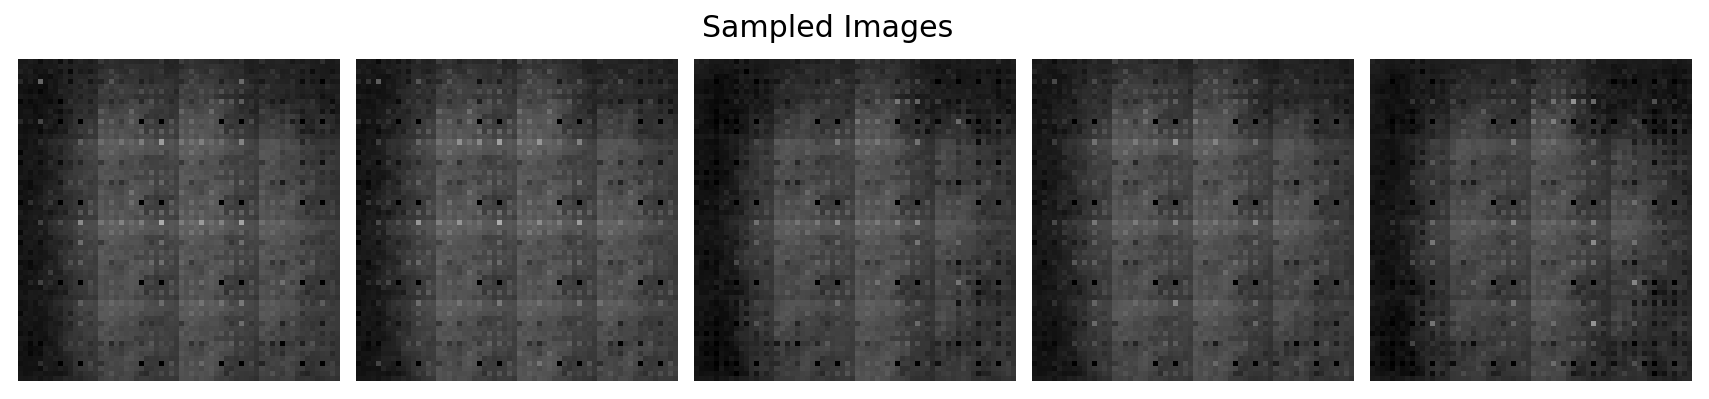

[1e+02/1e+03 12.0%][kl_weight:0.50] [LOSS] TOTAL[13.6]=RECON[13.5]+KL[0.4]
[1e+02/1e+03 14.0%][kl_weight:0.50] [LOSS] TOTAL[13.2]=RECON[13.0]+KL[0.4]
[2e+02/1e+03 16.0%][kl_weight:0.50] [LOSS] TOTAL[12.3]=RECON[12.0]+KL[0.5]
[2e+02/1e+03 18.0%][kl_weight:0.50] [LOSS] TOTAL[12.3]=RECON[12.0]+KL[0.5]
[2e+02/1e+03 20.0%][kl_weight:0.50] [LOSS] TOTAL[11.0]=RECON[10.7]+KL[0.6]


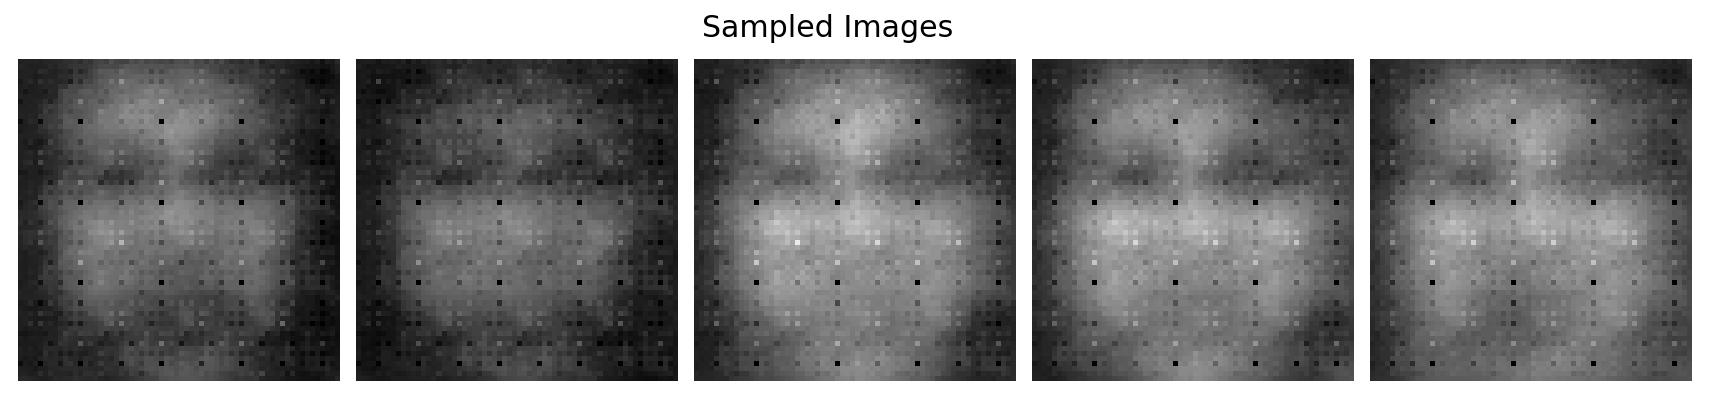

In [ ]:
sess = gpusession()
sess.run(tf.global_variables_initializer())
MAXITER,BATCHSIZE = (int)(1e3),64
PRINTEVERY,PLOTEVERY = (int)(MAXITER/50),(int)(MAXITER/10)
for ITER in range(MAXITER):
    RATE      = (float)(ITER)/(float)(MAXITER)
    offset    = (ITER*BATCHSIZE)%(ntrain) 
    batch_x   = trainimg[offset:(offset+BATCHSIZE),:]
    kl_weight = 0.5
    feeds = {V.x:batch_x,V.is_training:True,V.kl_weight:kl_weight}
    tfops = [V.solver,V.total_loss,V.recon_loss,V.kl_loss]
    _,total_loss,recon_loss,kl_loss=sess.run(tfops,feed_dict=feeds)
    if ITER % PRINTEVERY == 0:
        print ("[%.0e/%.0e %.1f%%][kl_weight:%.2f] [LOSS] TOTAL[%.1f]=RECON[%.1f]+KL[%.1f]"%
               (ITER,MAXITER,RATE*100.,kl_weight,total_loss,recon_loss,kl_loss))
    if ITER % PLOTEVERY == 0:
        nr,nc = 1,5
        varying_z = np.random.randn(nr*nc,V.zdim)
        feeds = {V.z:varying_z,V.is_training:False}
        samples = sess.run(V.xrecon_test, feed_dict=feeds)
        samples = np.clip(samples,0.0,1.0)
        plot_grid_imgs(samples,_nr=nr,_nc=nc,_imgshp=xshp,_figsize=(15,3),
                       _title='Sampled Images')
print ("Done")

Save

In [ ]:
V.save(_sess=sess,_savename='net/net_dcvae.npz')

Initialize 

In [ ]:
sess.run(tf.global_variables_initializer())
varying_z = np.random.randn(nr*nc,V.zdim)
feeds   = {V.z:varying_z,V.is_training:False}
samples = sess.run(V.xrecon_test, feed_dict=feeds)
samples = np.clip(samples,0.0,1.0)
plot_grid_imgs(samples,_nr=nr,_nc=nc,_imgshp=xshp,_figsize=(15,3),
               _title='Sampled Images')

Restore

In [ ]:
V.restore(_sess=sess,_loadname='net/net_dcvae.npz')
varying_z = np.random.randn(nr*nc,V.zdim)
feeds   = {V.z:varying_z,V.is_training:False}
samples = sess.run(V.xrecon_test, feed_dict=feeds)
samples = np.clip(samples,0.0,1.0)
plot_grid_imgs(samples,_nr=nr,_nc=nc,_imgshp=xshp,_figsize=(15,3),
               _title='Sampled Images')